In [1]:
%load_ext nb_mypy
%nb_mypy Off

Version 1.0.5


In [2]:
from __future__ import annotations
import numpy as np
import random
import copy

from typing import Tuple, List
from numpy import array, zeros

# from Big_Class import Big_Class  # already imported one NETfuncs is imported
from User_Variables import User_Variables  # already imported one NETfuncs is imported
from Network_Structure import Network_Structure  # already imported one NETfuncs is imported
from Big_Class import Big_Class
from Network_State import Network_State
from Networkx_Net import Networkx_Net
import NETfuncs, matrix_functions, functions, statistics, plot_functions, solve

In [3]:
## Parameters

Nin: int = 2
Nout: int = 2

# learning rate
# alpha_vec = np.array([0.2, 0.5, 1.0, 2.0, 2.5, 2.7, 3.5, 4.0, 8.0])  # 1D array = const alpha, array of arrays = annealed
# alpha_vec = np.array([np.append(np.linspace(4.1,4.8,200), np.linspace(4.8,4.1,200))])  # 1D array for constant alpha, array of arrays for annealed alpha
alpha_vec: np.ndarray = np.array([0.2])  # for allostery, regression and general_reg
# alpha_vec = np.array([0.1])  # for general_reg_allRsChange
# alpha_vec = np.array([np.linspace(5,3.85,40)])  # 1D array for constant alpha, array of arrays for annealed alpha
# alpha_vec = np.array([4.8])

# resistance-pressure proportionality factor
gamma: np.ndarray = np.array([1.0])

R_update: str = 'propto'
# R_update = 'deltaR'

# training length
if np.size(alpha_vec[0])>1:  # if alpha is annealed
    iterations: int = len(alpha_vec[0])
else:
    iterations = 320
    
supress_prints: bool = False
bc_noise: float = 0.0
use_p_tag: bool = True
    
M_values: np.ndarray = array([0.05, 0.25, 0.1, 0.15, 0.02, 0.3, 0.35, 0.15])
    
## Networkx sizes
scale: float = 5.0
squish: float = 0.01

In [4]:
## Assign input and output nodes a.f.o lattice size and row choice
input_nodes_arr, ground_nodes_arr, output_nodes_arr = matrix_functions.build_input_output_and_ground(Nin, Nout)

In [5]:
print('input_nodes_arr ', input_nodes_arr)
print('output_nodes_arr ', output_nodes_arr)
print('ground_nodes_arr ', ground_nodes_arr)

input_nodes_arr  [0 1]
output_nodes_arr  [2 3]
ground_nodes_arr  [4]


In [6]:
## Variables class - mostly user choices
Variabs = User_Variables(iterations,\
                         Nin, \
                         Nout, \
                         alpha_vec, \
                         gamma, \
                         R_update, \
                         use_p_tag, \
                         supress_prints, \
                         bc_noise)

Variabs.create_M(M_values)

In [7]:
Variabs.M

array([[0.05, 0.25],
       [0.1 , 0.15]])

In [8]:
## Big Class containing all classes in Network Simulation
BigClass = Big_Class(Variabs)

In [9]:
## Structure class - build incidence matrices and 1d arrays of edges

Strctr = Network_Structure(input_nodes_arr, \
                           output_nodes_arr, \
                           ground_nodes_arr,)
Strctr.build_incidence()
Strctr.build_edges()
BigClass.add_Strctr(Strctr)  # add to big class
# # Identify edges at connections of cells and at boundaries for ease of use
# Strctr.Boundaries_and_connections(BigClass)

EI [0 0 1 1 0 1 2 3]
EJ [2 3 2 3 4 4 4 4]
NE 8


In [10]:
## Initiate internal flow network state class

State = Network_State(Nin, Nout)
BigClass.add_State(State)  # add to big class

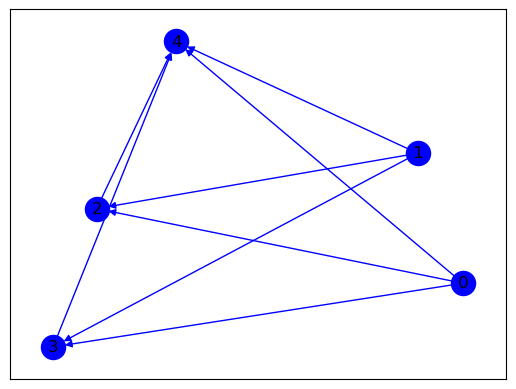

NET is ready


In [11]:
## build network graphics class and plot structure

NET = Networkx_Net(scale, squish)
NET.buildNetwork(BigClass)
NET.build_pos_lattice(BigClass, plot=True, node_labels=True)
# pos_lattice = NETfuncs.plotNetStructure(NET.NET, plot='yes', node_labels=False)  # position lattice, datatype of networkx
# position lat. dtype=networkx
# pos_lattice = NETfuncs.plotNetStructure(NET.NET, layout='oneCol', plot='no', node_labels=True)
# print(NET.pos_lattice)
BigClass.add_NET(NET)  # add to big class

## Start loop from here

In [12]:
%nb_mypy On

In [13]:
State.draw_p_in_and_desired(Variabs)

<cell>1: error: Name "State" is not defined  [name-defined]
<cell>1: error: Name "Variabs" is not defined  [name-defined]


In [14]:
print('p_drawn ', State.p_drawn)
print('p_drawn_in_t ', State.p_drawn_in_t)
print('desired output', State.desired)
print('desired output in time', State.desired_in_t)

<cell>1: error: Name "State" is not defined  [name-defined]
<cell>2: error: Name "State" is not defined  [name-defined]
<cell>3: error: Name "State" is not defined  [name-defined]
<cell>4: error: Name "State" is not defined  [name-defined]


p_drawn  [0.06454994 1.8294558 ]
p_drawn_in_t  [array([0.06454994, 1.8294558 ])]
desired output [0.46059145 0.28087336]
desired output in time [array([0.46059145, 0.28087336])]


In [15]:
Cstr_full, Cstr, f = State.setup_constraints_given_pin(BigClass, "measure")

<cell>1: error: Name "State" is not defined  [name-defined]
<cell>1: error: Name "BigClass" is not defined  [name-defined]


BigClass input nodes [0 1]
InNodes [0 1]
Nodes inside func [0 1]
NodeData [0.06454994 1.8294558 ]
Nodes [0 1]
GroundNodes [4]


(array([[0.        , 0.        , 0.        , 0.        , 1.        ,
         0.        ],
        [1.        , 0.        , 0.        , 0.        , 0.        ,
         0.06454994],
        [0.        , 1.        , 0.        , 0.        , 0.        ,
         1.8294558 ]]),
 array([[0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0.]]),
 array([[0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.06454994],
        [1.8294558 ]]))

In [ ]:
State.p, State.u = State.solve_flow_until_conv(BigClass, u, State.setup_constraints_given_pin(BigClass, "measure"))

In [16]:
for i in range(Variabs.iterations):
    State.draw_p_in_and_desired()
    desired = np.matmul(M, state.p_drawn)
    state.desired_in_t.append(desired)
    if supress:
        pass
    else:
        print('p_drawn', state.p_drawn)
        print('desired', desired)
    state.calc_output(syms)
    if not i % 2:  # even iterations
        pass
    else:
        if use_p_tag:
            state.calc_loss(desired, state.out_in_t[-2], state.desired_in_t[-2])
        else:
            state.calc_loss(desired)
        state.update_pressure()
        state.update_BCs(desired)
        state.update_Rs()
    plot_functions.plot_importants(state, variabs, desired, A, B)

<cell>1: error: Name "Variabs" is not defined  [name-defined]
<cell>2: error: Name "State" is not defined  [name-defined]
<cell>3: error: Name "np" is not defined  [name-defined]
<cell>3: error: Name "M" is not defined  [name-defined]
<cell>3: error: Name "state" is not defined  [name-defined]
<cell>4: error: Name "state" is not defined  [name-defined]
<cell>5: error: Name "supress" is not defined  [name-defined]
<cell>8: error: Name "state" is not defined  [name-defined]
<cell>10: error: Name "state" is not defined  [name-defined]
<cell>10: error: Name "syms" is not defined  [name-defined]
<cell>14: error: Name "use_p_tag" is not defined  [name-defined]
<cell>15: error: Name "state" is not defined  [name-defined]
<cell>17: error: Name "state" is not defined  [name-defined]
<cell>18: error: Name "state" is not defined  [name-defined]
<cell>19: error: Name "state" is not defined  [name-defined]
<cell>20: error: Name "state" is not defined  [name-defined]
<cell>21: error: Name "plot_func

TypeError: draw_p_in_and_desired() missing 1 required positional argument: 'Variabs'

In [ ]:
## functions

def run_model_changing_alpha(alpha_vec, task_type, training, supress, bc_noise=0, use_p_tag=True, \
                             R_update: str ='propto') -> Tuple["State", "User_Variables", np.ndarray]:
    variabs = Variabs(task_type, alpha, gamma, use_p_tag=use_p_tag, R_update=R_update)

    ## network state
    state = State(Variabs, supress_prints, bc_noise, Strctr, Nin, Nout)
        
    for i in range(training):
        if task_type=='Allostery':
            if np.size(alpha)>2:  # if alpha is annealed, change. In allostery alpha is 2D anyway
                state.update_alpha(alpha[i])
            state.calc_output(syms)
            state.calc_loss(desired)
            state.update_pressure()
            state.update_BCs(desired)
            state.update_Rs()
        else:
            state.draw_p()
            desired = np.matmul(M, state.p_drawn)
            state.desired_in_t.append(desired)
            if supress:
                pass
            else:
                print('p_drawn', state.p_drawn)
                print('desired', desired)
            state.calc_output(syms)
            if not i % 2:  # even iterations
                pass
            else:
                if use_p_tag:
                    state.calc_loss(desired, state.out_in_t[-2], state.desired_in_t[-2])
                else:
                    state.calc_loss(desired)
                state.update_pressure()
                state.update_BCs(desired)
                state.update_Rs()
        plot_functions.plot_importants(state, variabs, desired, A, B)
    return state, variabs, desired

In [ ]:
## Big Class containing all classes in Network Simulation
BigClass = Big_Class.Big_Class(Variabs)

# CPU or GPU usage
BigClass.assign_solver(solver)

## Structure class - build incidence matrices and 1d arrays of edges

Strctr = Classes.Net_structure()
Strctr.build_incidence(Variabs)
if Variabs.task_type == 'Memristor' or Variabs.task_type == 'Allostery_contrastive' or Variabs.task_type == 'Regression_contrastive':
    Variabs.update_u_thresh(Strctr)
BigClass.add_Strctr(Strctr)  # add to big class
# Identify edges at connections of cells and at boundaries for ease of use
Strctr.Boundaries_and_connections(BigClass)